# Using NNI Python APIs

NNI provides `nnicli` module as a python wrapper for its restful API clients, which can be used to control and query NNI experiments and trial jobs in your python code. This notebook shows how to use `nnicli` module.

The APIs available once you installed via `pip install nni`. For detailed API reference, please refer to [this page](https://nni.readthedocs.io/en/latest/nnicli_ref.html).

In [1]:
from nnicli import Experiment

It is compatible with **AdaptDL** if the installation requirements in "Getting Started" are satisfied:  (i) Petuum build of `nni==<version>+petuum` and (ii)  `.kube/config` file to access the training cluster with AdaptDL scheduler.

## Start  an Experiment

Let's use a configruation file in nni examples directory to start an experiment.

In [2]:
! cat ./config_adl.yml

authorName: default
experimentName: example_mnist_pytorch
trialConcurrency: 1
maxExecDuration: 1h
maxTrialNum: 10

nniManagerIp: 10.20.100.121
logCollection: http
trainingServicePlatform: adl

searchSpacePath: search_space.json
useAnnotation: false
tuner:
  builtinTunerName: TPE
  classArgs:
    optimize_mode: maximize

trial:
  image: registry.petuum.com/dev/train-demo:mnist-pytorch-adl
  imagePullSecrets:
    - name: stagingsecret
  command: python3 mnist.py
  codeDir: .
  gpuNum: 1


In [3]:
from nnicli import Experiment

# create an experiment instance
exp = Experiment() 

# start an experiment, then connect the instance to this experiment
# you can also use `resume_experiment`, `view_experiment` or `connect_experiment`
# only one of them should be called in one instance
exp.start_experiment('./config_adl.yml', port=8080)

INFO:  expand searchSpacePath: search_space.json to /Users/ubuntu/workspace/nni/examples/trials/mnist-pytorch/search_space.json
INFO:  expand codeDir: . to /Users/ubuntu/workspace/nni/examples/trials/mnist-pytorch/.
INFO:  Starting restful server...
INFO:  Successfully started Restful server!
INFO:  Setting adl config...
INFO:  Successfully set adl config!
INFO:  Starting experiment...
INFO:  Successfully started experiment!
------------------------------------------------------------------------------------
The experiment id is raMAGcBW
The Web UI urls are: 10.20.100.121:8080
------------------------------------------------------------------------------------

You can use these commands to get more information about the experiment
------------------------------------------------------------------------------------
commands                       description
1. nnictl experiment show        show the information of experiments
2. nnictl trial ls               list all of trial jobs
3. nn

In [4]:
# update the experiment's concurrency
exp.update_concurrency(2)

INFO:  Update concurrency success!


## Connect a Running Experiment

Connect `nnicli` moduele to the rest server of started nni experiment. Local mode training serviced is used in this notebook, but nnicli module can connect to any started nni experiment. The endpoint can be found in the output of `start_experiment` function.

In [5]:
exp = Experiment()
exp.connect_experiment('http://127.0.0.1:8080')

## Retrieve Experiment Information

In [6]:
profile = exp.get_experiment_profile()
print(profile)

{'params': {'authorName': 'default', 'experimentName': 'example_mnist_pytorch', 'trialConcurrency': 1, 'maxExecDuration': 3600, 'maxTrialNum': 10, 'searchSpace': '{"batch_size": {"_type": "choice", "_value": [16, 32, 64, 128]}, "hidden_size": {"_type": "choice", "_value": [128, 256, 512, 1024]}, "lr": {"_type": "choice", "_value": [0.0001, 0.001, 0.01, 0.1]}, "momentum": {"_type": "uniform", "_value": [0, 1]}}', 'trainingServicePlatform': 'adl', 'tuner': {'builtinTunerName': 'TPE', 'classArgs': {'optimize_mode': 'maximize'}, 'checkpointDir': '/Users/ubuntu/nni-experiments/xpX702bz/checkpoint'}, 'versionCheck': True, 'clusterMetaData': []}, 'id': 'xpX702bz', 'execDuration': 2956, 'startTime': 1600621903511, 'logDir': '/Users/ubuntu/nni-experiments/xpX702bz', 'nextSequenceId': 11, 'revision': 309, 'endTime': 1600625066979}


In [7]:
print('Is it using AdaptDL scheduler?:', profile['params']['trainingServicePlatform'] == 'adl')

Is it using AdaptDL scheduler?: True


In [8]:
exp.get_experiment_status()

{'status': 'DONE', 'errors': []}

In [9]:
trial_jobs = exp.list_trial_jobs()
print(len(trial_jobs))
print(trial_jobs)

10
[TrialJob(trialJobId: CBRq5 status: SUCCEEDED hyperParameters: [TrialHyperParameters(parameter_id: 0 parameter_source: algorithm parameters: {'batch_size': 64, 'hidden_size': 128, 'lr': 0.01, 'momentum': 0.405889181698159} parameter_index: 0)] logPath: output startTime: 1600621908000 endTime: 1600622107273 finalMetricData: [TrialMetricData(timestamp: 1600622094503 trialJobId: CBRq5 parameterId: 0 type: FINAL sequence: 0 data: 99.02)] stderrPath: None), TrialJob(trialJobId: ah7rc status: SUCCEEDED hyperParameters: [TrialHyperParameters(parameter_id: 1 parameter_source: algorithm parameters: {'batch_size': 128, 'hidden_size': 128, 'lr': 0.1, 'momentum': 0.6306322181873855} parameter_index: 0)] logPath: output startTime: 1600622115000 endTime: 1600622259927 finalMetricData: [TrialMetricData(timestamp: 1600622248490 trialJobId: ah7rc parameterId: 1 type: FINAL sequence: 0 data: 99.16)] stderrPath: None), TrialJob(trialJobId: ntGry status: SUCCEEDED hyperParameters: [TrialHyperParameters

In [10]:
example_trial_id = trial_jobs[0].trialJobId
print(example_trial_id)

CBRq5


In [11]:
exp.get_trial_job(trial_job_id=example_trial_id)

TrialJob(trialJobId: CBRq5 status: SUCCEEDED hyperParameters: [TrialHyperParameters(parameter_id: 0 parameter_source: algorithm parameters: {'batch_size': 64, 'hidden_size': 128, 'lr': 0.01, 'momentum': 0.405889181698159} parameter_index: 0)] logPath: output startTime: 1600621908000 endTime: 1600622107273 finalMetricData: [TrialMetricData(timestamp: 1600622094503 trialJobId: CBRq5 parameterId: 0 type: FINAL sequence: 0 data: 99.02)] stderrPath: None)

In [12]:
example_metrics = exp.get_job_metrics(trial_job_id=example_trial_id)
print(example_metrics)

{'CBRq5': [TrialMetricData(timestamp: 1600621976809 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 0 data: 96.77), TrialMetricData(timestamp: 1600621989736 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 1 data: 97.92), TrialMetricData(timestamp: 1600622002913 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 2 data: 98.28), TrialMetricData(timestamp: 1600622016024 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 3 data: 98.16), TrialMetricData(timestamp: 1600622029004 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 4 data: 98.43), TrialMetricData(timestamp: 1600622042099 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 5 data: 98.69), TrialMetricData(timestamp: 1600622055301 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 6 data: 98.78), TrialMetricData(timestamp: 1600622068472 trialJobId: CBRq5 parameterId: 0 type: PERIODICAL sequence: 7 data: 98.92), TrialMetricData(timestamp: 1600622081582 trialJobId: 

## Visualizing Experiment Metrics (Optional)

With the retrieved trial job information, we can do some analysis by visualizing the metric data, below is a simple example.

In [13]:
! pip install matplotlib
! pip install seaborn

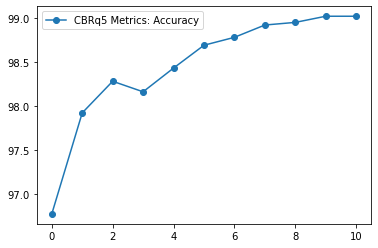

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot([x.data for x in example_metrics[example_trial_id]], '-o', 
         markevery=1,
         label='%s Metrics: Accuracy' % example_trial_id)
plt.legend()

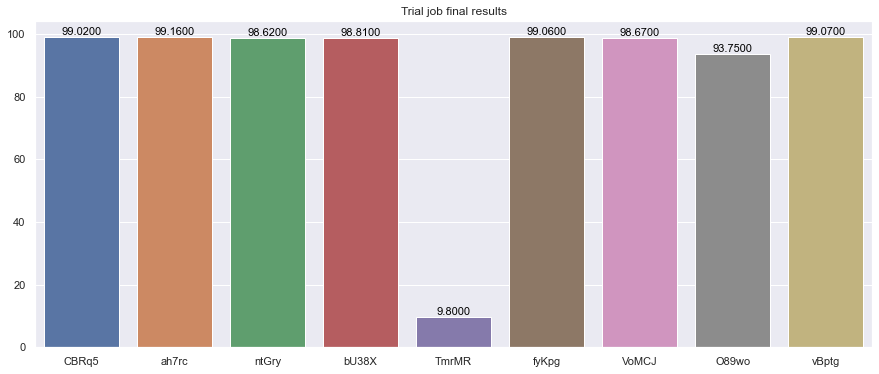

In [15]:
sns.set(style="whitegrid")

trial_jobs = exp.list_trial_jobs()
job_ids = [x.trialJobId for x in trial_jobs if x.status == 'SUCCEEDED']
final_metrics = [float(x.finalMetricData[0].data) for x in trial_jobs if x.status == 'SUCCEEDED']

data = {'job id': job_ids, 'final metrics': final_metrics}
sns.set(rc={'figure.figsize':(15, 6)})

plt.title('Trial job final results')
ax = sns.barplot(x='job id', y='final metrics', data=data) 

for i,p in enumerate(ax.patches):
    ax.annotate('{:.4f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', rotation=0, xytext=(0, 5),
                 textcoords='offset points') 

##  Other APIs

For detailed API reference, please refer to [this page](https://nni.readthedocs.io/en/latest/nnicli_ref.html).

In [16]:
exp.stop_experiment()

INFO:  Stopping experiment xpX702bz
INFO:  Stop experiment success.


In [17]:
another_exp = Experiment()
another_exp.resume_experiment(exp_id='xpX702bz')

INFO:  resume experiment xpX702bz...
INFO:  Starting restful server...
INFO:  Successfully started Restful server!
INFO:  Setting adl config...
INFO:  Successfully set adl config!
INFO:  Starting experiment...
INFO:  Successfully started experiment!
------------------------------------------------------------------------------------
The experiment id is xpX702bz
The Web UI urls are: 10.20.100.121:8080
------------------------------------------------------------------------------------

You can use these commands to get more information about the experiment
------------------------------------------------------------------------------------
commands                       description
1. nnictl experiment show        show the information of experiments
2. nnictl trial ls               list all of trial jobs
3. nnictl top                    monitor the status of running experiments
4. nnictl log stderr             show stderr log content
5. nnictl log stdout             show stdout log con